- Ana Sofía Escobar - 20489
- Wilfredo Gallegos
- Stefan Quintana
- Jorge Caballeros

# Proyecto Final - Mineria de datos

In [6]:
import pandas as pd
import numpy as np
import scipy.stats as st
import itertools
import statsmodels.api as sm
from scipy.stats import contingency
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import plot_tree
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree

from tensorflow.keras.models import Model, Sequential, load_model, save_model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras import optimizers
 
plt.style.use('ggplot')

In [7]:
# Cargar los datos
muertes = pd.read_csv('final.csv')
# Quitar causa de muerte y edad ya que es información no necesaria
muertes = muertes.loc[:, muertes.columns != 'Tiempo']
muertes = muertes.loc[:, muertes.columns != 'Causa2']

C:\Users\jorge\AppData\Local\Temp\ipykernel_25636\3310959997.py:2: DtypeWarning: Columns (0,7,12,18,22,26) have mixed types. Specify dtype option on import or set low_memory=False.
  muertes = pd.read_csv('final.csv')


In [8]:
#Organizar los datos por columnas y causas
muertes['cause'] = muertes['Causa1'].copy()
repl = {r'([AB])(\d+.*)' : r'AB', r'(C)(\d+.*)' : r'CD',  r'(D[0-4])(\d+.*)' : r'CD', r'(D[5-8])(\d+.*)' : r'DD', r'(E)(\d+.*)' : r'EE',
        r'(F)(\d+.*)' : r'FF', r'(G)(\d+.*)' : r'GG', r'(H[0-5])(\d+.*)' : r'HA', r'(H[6-9])(\d+.*)' : r'HB', r'(I)(\d+.*)' : r'II',
        r'(J)(\d+.*)' : r'JJ', r'(K)(\d+.*)' : r'KK', r'(L)(\d+.*)' : r'LL', r'(M)(\d+.*)' : r'MM', r'(N)(\d+.*)' : r'NN',
        r'(O)(\d+.*)' : r'OO', r'(P)(\d+.*)' : r'PP', r'(Q)(\d+.*)' : r'QQ', r'(R)(\d+.*)' : r'RR', r'([ST])(\d+.*)' : r'ST',
        r'([VWXY])(\d+.*)' : r'VY', r'([Z])(\d+.*)' : r'ZZ', r'([U])(\d+.*)' : r'UU',
        }
muertes.cause = muertes['cause'].replace(repl, regex=True)
muertes['cause']

0         II
1         UU
2         RR
3         PP
4         UU
          ..
809291    AB
809292    AB
809293    AB
809294    AB
809295    AB
Name: cause, Length: 809296, dtype: object

In [9]:
# Eliminación de toda la información que no nos interesa
sample = muertes.drop(['Coma', 'Departamento', 'Municipio', 'Mes', 'Year','Municipio2',
                      'Edad','Pueblo','Civil','Escolaridad','Ciudad','Pais','Dep3',
                      'Muni3', 'Pais2', 'Predif', 'Dredif', 'Mredif', 'Sexo', 'Causa1'], axis=1)

In [10]:
# Creación de la nueva variable de predicción
# Variable de predicción: número de muertes por municipio_ocurrencia/mes_ocurrencia y causa
sample = sample.groupby(by=['cause','Departamento2', 'Mes2', 'Dia', 'Year2', 'Asistencia', 
                            'Lugar', 'Cerdef']).count()
sample.columns = ['number_deaths']

In [11]:
# Nuevo conjunto de datos
sample = sample.reset_index(level=['cause', 'Mes2', 'Dia', 'Year2', 'Asistencia', 'Lugar','Cerdef','Departamento2'])

<Axes: xlabel='number_deaths', ylabel='Count'>

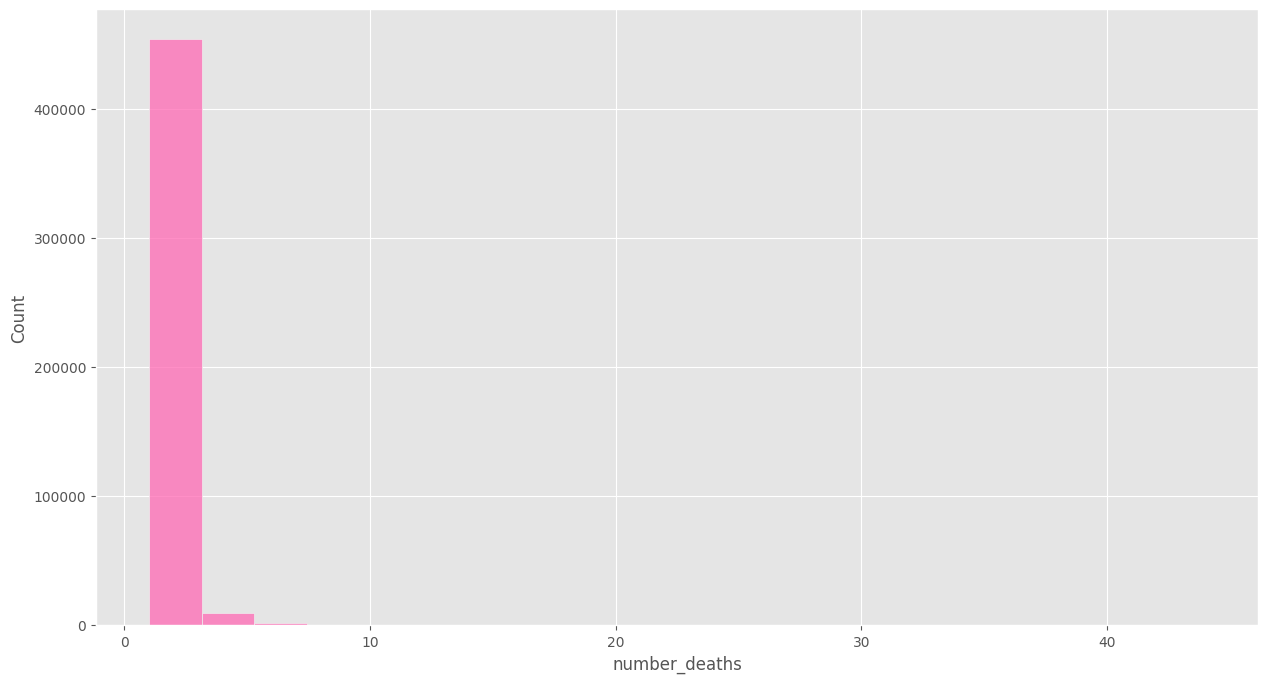

In [12]:
#Gráfica de la distribución de la variable objetivo
plt.figure(figsize=(15, 8))
sns.histplot(sample.number_deaths, color = 'hotpink')

In [13]:
# Evaluar la correlación de las variables
for column in sample.columns:
  if column != 'cause':
    crosstable = pd.crosstab(sample[column], sample['cause'])
    print(crosstable)
    print('Asociación: ', contingency.association(crosstable))

cause             AB     CD    DD     EE   FF    GG  HA  HB     II    JJ   
Departamento2                                                              
Alta Verapaz    3803   2168   658   2954   64   522   5   4   3012  4864  \
Baja Verapaz     415    913    50    722   29   152   3   0   1751  1081   
Chimaltenango    692   1863   147   1773  202   270   0   0   2516  2631   
Chiquimula       567   1278   113   1105   35   260   0   0   2627  1597   
El Progreso      143    845    21    682   16   110   0   0   1550   550   
Escuintla       1461   2608   452   3551  105   610   0   3   4155  2733   
Guatemala       5622  11898  1553  10864  955  3477   5   7  13917  9582   
Huehuetenango   2438   3128   236   2692  117   749   1   2   4019  4165   
Izabal           930   1092   136   1227   29   250   0   1   2300  1021   
Jalapa           559   1125    60    731   28   334   0   0   1876  1205   
Jutiapa          411   1903    96   1568   54   287   1   0   4042  1132   
Peten       

In [14]:
# Eliminando las variables correlacionadas
sample = sample.drop(['Asistencia', 'Dia', 'Cerdef'], axis=1)

In [15]:
# Agrupando nuevamente
sample = sample.groupby(['cause', 'Lugar','Departamento2', 'Year2', 'Mes2']).count()
sample = sample.reset_index(level=['cause', 'Lugar','Departamento2', 'Year2', 'Mes2'])

0        1
1        1
2        1
3        1
4        1
        ..
83817    1
83818    3
83819    1
83820    1
83821    2
Name: number_deaths, Length: 83822, dtype: int64

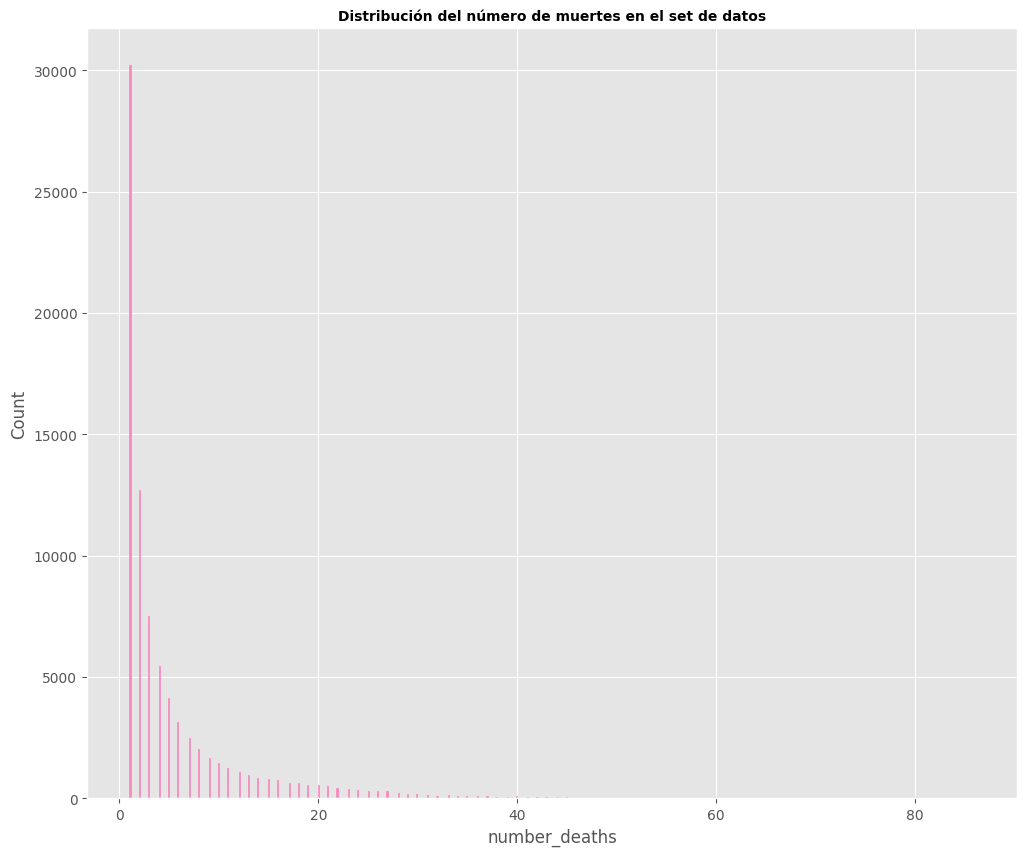

In [16]:
plt.figure(figsize=(12, 10))
sns.histplot(sample.number_deaths, color = 'hotpink')
plt.title('Distribución del número de muertes en el set de datos', fontsize = 10, fontweight = "bold")
sample.number_deaths

In [17]:
# Codificación de las variables
codificacion = OrdinalEncoder(dtype=int)
for column in sample.columns:
        if column != 'number_deaths':
                sample[column] = codificacion.fit_transform(sample[[column]])
                print(codificacion.categories_)

[array(['AB', 'CD', 'DD', 'EE', 'FF', 'GG', 'HA', 'HB', 'II', 'JJ', 'KK',
       'LL', 'MM', 'NN', 'OO', 'PP', 'QQ', 'RR', 'UU', 'VY'], dtype=object)]
[array(['Centro de salud', 'Domicilio', 'Hospital privado',
       'Hospital público', 'Ignorado', 'Lugar de trabajo', 'Otro',
       'Seguro social', 'Vía pública'], dtype=object)]
[array(['Alta Verapaz', 'Baja Verapaz', 'Chimaltenango', 'Chiquimula',
       'El Progreso', 'Escuintla', 'Guatemala', 'Huehuetenango', 'Izabal',
       'Jalapa', 'Jutiapa', 'Peten', 'Petén', 'Quetzaltenango', 'Quiche',
       'Quiché', 'Retalhuleu', 'Sacatepequez', 'Sacatepéquez',
       'San Marcos', 'Santa Rosa', 'Solola', 'Sololá', 'Suchitepequez',
       'Totonicapan', 'Totonicapán', 'Zacapa'], dtype=object)]
[array([2011., 2012., 2013., 2014., 2015., 2016., 2017., 2018., 2019.,
       2020.])]
[array(['Abril', 'Agosto', 'Diciembre', 'Enero', 'Febrero', 'Julio',
       'Junio', 'Marzo', 'Mayo', 'Noviembre', 'Octubre', 'Septiembre'],
      dtype=object)]


In [18]:
# Variables  predecir
target = sample.number_deaths
predictors = sample.loc[:, sample.columns != 'number_deaths']
# Conjuntos de entrenamiento y prueba
predictors_train, predictors_test, target_train, target_test = train_test_split(predictors, target, test_size=0.33,
                                                                                stratify=predictors['cause'], random_state=190243)

# Redes neuronales

In [19]:
predictors

,cause,Lugar,Departamento2,Year2,Mes2
0,0,0,0,1,0
1,0,0,0,1,8
2,0,0,0,3,1
3,0,0,0,3,6
4,0,0,0,4,6
...,...,...,...,...,...
83817,19,8,26,9,6
83818,19,8,26,9,8
83819,19,8,26,9,9
83820,19,8,26,9,10


In [20]:
#Forma de los datos
print('Train')
print('Predictors: ', predictors_train.shape, 'Target:', target_train.shape)
print('Test')
print('Predictors: ', predictors_test.shape, 'Target:', target_test.shape)

sample_shape = predictors_train.shape[1:]
print('Data shape:', sample_shape)

Train
Predictors:  (56160, 5) Target: (56160,)
Test
Predictors:  (27662, 5) Target: (27662,)
Data shape: (5,)


In [21]:
# Creamos el modelo de la red neuroal con capas
# Capas de la red
def create_network():
    input = Input(shape=sample_shape, name='input')
    process = Dense(64, activation='relu', name='dense2')(input)
    process = Dense(16, activation='relu', name='dense3')(process)
    dropout = Dropout(0.15, name='dropout')(process)
    process = Dense(8, activation='relu', name='dense4')(process)
    process = Dense(1, activation=None, name='regressor')(process)
    # Creación del modelo
    nn_model = Model(input, process, name='Number_deaths')
    # Compilando el modelo
    optimizer = optimizers.Adam(learning_rate=1e-4, epsilon=1e-6)
    nn_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return nn_model

In [22]:
modelo1 = create_network()
# Entrenamiento de las redes
history = modelo1.fit(predictors_train, target_train, epochs=40, batch_size=128, validation_split=0.15)

Epoch 1/40
373/373 [==============================] - 2s 2ms/step - loss: 71.8427 - mae: 4.8106 - val_loss: 62.9471 - val_mae: 4.9102
Epoch 2/40
373/373 [==============================] - 1s 2ms/step - loss: 61.5939 - mae: 4.8892 - val_loss: 60.0838 - val_mae: 4.9525
Epoch 3/40
373/373 [==============================] - 1s 2ms/step - loss: 59.6020 - mae: 4.8658 - val_loss: 58.8741 - val_mae: 4.8316
Epoch 4/40
373/373 [==============================] - 1s 2ms/step - loss: 58.5851 - mae: 4.8248 - val_loss: 57.9683 - val_mae: 4.8758
Epoch 5/40
373/373 [==============================] - 1s 2ms/step - loss: 57.7955 - mae: 4.8012 - val_loss: 57.2462 - val_mae: 4.7559
Epoch 6/40
373/373 [==============================] - 1s 2ms/step - loss: 57.1197 - mae: 4.7726 - val_loss: 56.6060 - val_mae: 4.8150
Epoch 7/40
373/373 [==============================] - 1s 2ms/step - loss: 56.5152 - mae: 4.7580 - val_loss: 56.0287 - val_mae: 4.7459
Epoch 8/40
373/373 [==============================] - 1s 2ms/s

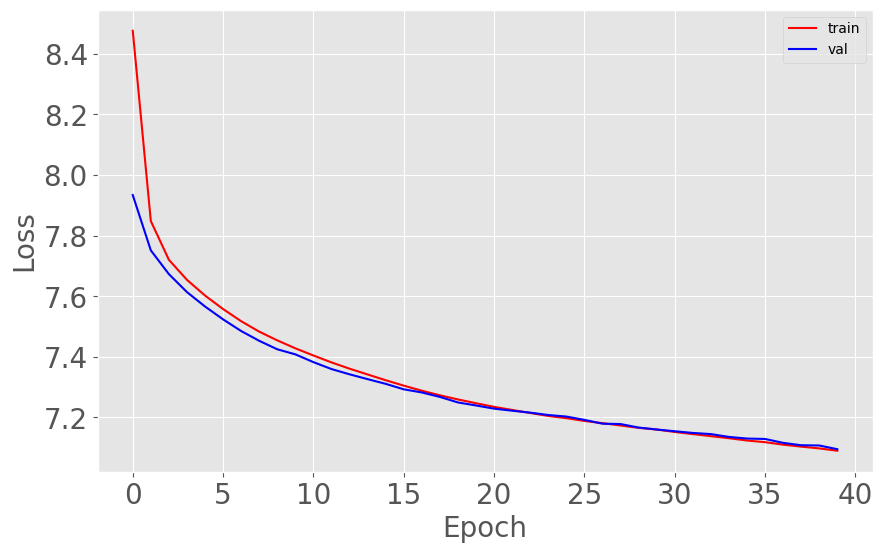

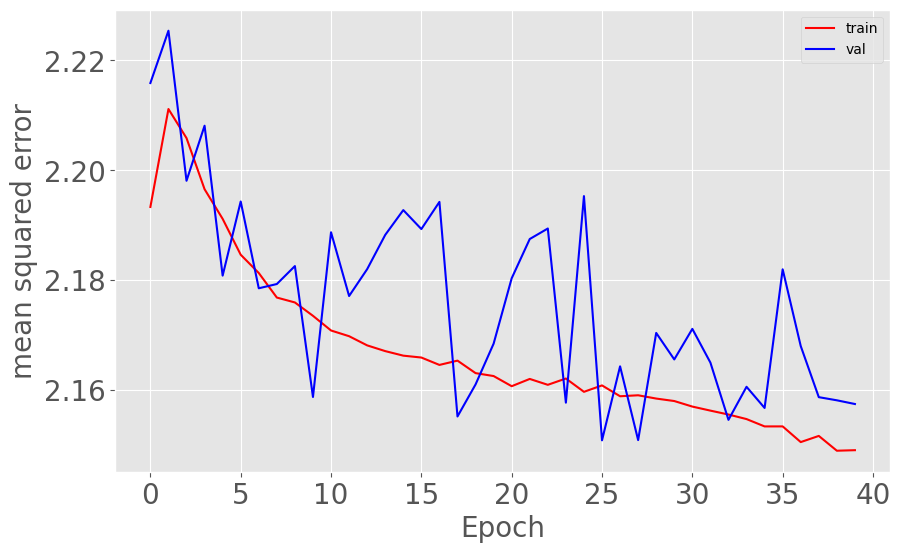

In [23]:
#Grafico de comparacion entre el objetivo y la prediccion
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(history.history['loss']), 'r', label='train')
ax.plot(np.sqrt(history.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

#Gráfico de precisión
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(history.history['mae']), 'r', label='train')
ax.plot(np.sqrt(history.history['val_mae']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'mean squared error', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

In [24]:
#Predicciones
prediction = modelo1.predict(predictors_test)
prediction = np.squeeze(prediction)

865/865 [==============================] - 1s 926us/step


In [25]:
results = pd.DataFrame({
    'Predicción': prediction,
    'Real': target_test
})

print ("Varianza:",explained_variance_score(target_test, prediction))
print ("Mean absolute Error:", mean_absolute_error(target_test, prediction))
print ("Mean squared error:", mean_squared_error(target_test, prediction))

results.tail(10)

Varianza: 0.12892493687308926
Mean absolute Error: 4.686720723738365
Mean squared error: 52.50229490485637


,Predicción,Real
24975,2.368474,2
1048,10.844920,8
71415,6.702164,7
13642,1.254355,1
23876,8.674398,2
49532,7.162251,1
28526,8.376608,8
12023,8.104868,2
48855,5.574018,2
69882,4.064279,1


# Random Forest

In [26]:
# Multicolinealidad de las variables
datarandfor = pd.DataFrame() 
G = sample
datarandfor["feature"] = G.columns
datarandfor["VIF"] = [variance_inflation_factor(G.values, i) for i in range(len(G.columns))]
print(datarandfor)

         feature       VIF
0          cause  3.128978
1          Lugar  2.650745
2  Departamento2  2.632861
3          Year2  2.859140
4           Mes2  2.864286
5  number_deaths  1.428708


In [27]:
#Basandonos en el análisis de multicolinealidad se debe hacer un drop del año de ocurrencia
target = sample.number_deaths
predictors = sample.loc[:, sample.columns != 'number_deaths']
predictors = predictors.drop('Year2', axis=1)

In [28]:
predictors_train, predictors_test, target_train, target_test = train_test_split(predictors, target, test_size=0.33, stratify=predictors['cause'])
print(predictors_train)

       cause  Lugar  Departamento2  Mes2
56229     14      3             13     6
38172      9      3              2    10
82011     19      8              4     5
48406     11      2              6     8
18736      3      3             14     5
...      ...    ...            ...   ...
53122     13      3              3     6
77236     19      4              1    11
15485      3      1             13     3
77809     19      4              6     9
56973     15      1              0    11

[56160 rows x 4 columns]


In [29]:
#creamos el modelo random forest
modelo2 = RandomForestRegressor(n_estimators=50, max_depth=15, random_state = 1000)
modelo2.fit(predictors_train,target_train)

RandomForestRegressor(max_depth=15, n_estimators=50, random_state=1000)

In [30]:
#prediccion del modelo
Y_pred = modelo2.predict(predictors_test)
YT_pred = modelo2.predict(predictors_train)

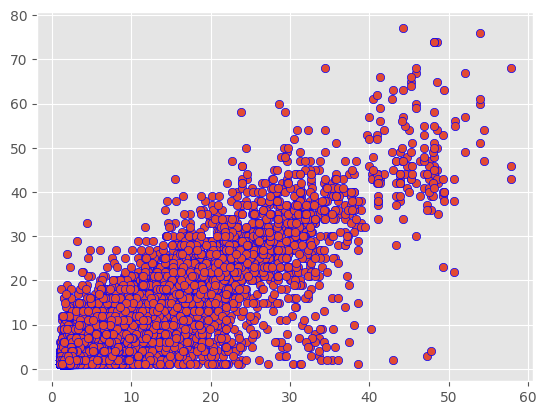

In [31]:
#grafico de la predicción
plt.scatter(Y_pred, target_test, edgecolors=(0, 0, 1))

In [32]:
#calculamos R^2 y estadisticos necesarios
print("R cuadrado: %.2f"%r2_score(target_test,Y_pred))
print("R cuadrado teórico: %.2f"%r2_score(target_train,YT_pred))
print ("Varianza:",explained_variance_score(target_test, Y_pred))
print ("Mean absolute Error:", mean_absolute_error(target_test, Y_pred))
print ("Mean squared error:", mean_squared_error(target_test, Y_pred))

R cuadrado: 0.79
R cuadrado teórico: 0.84
Varianza: 0.7864639705776121
Mean absolute Error: 2.0032755066811156
Mean squared error: 12.722188641447003


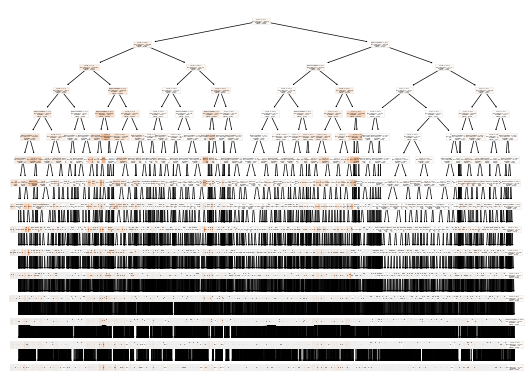

In [33]:
#graficamos el random forest
plt.figure()
_ = tree.plot_tree(modelo2.estimators_[0], feature_names=G.columns, filled=True)

Residuos del modelo

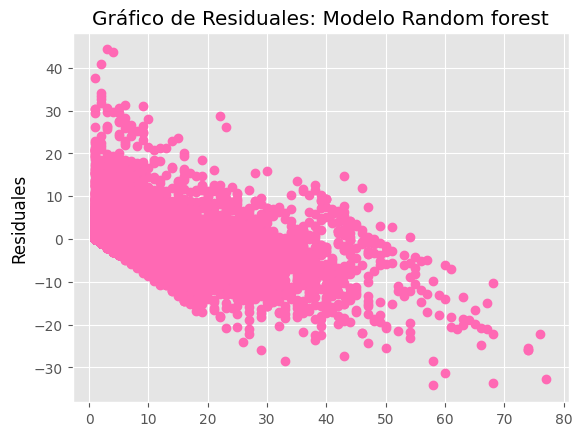

In [34]:
#calculamos los residuos
residuales = Y_pred - target_test

#graficamos
plt.plot(target_test,residuales, 'o', color='hotpink')
plt.title("Gráfico de Residuales: Modelo Random forest")
plt.ylabel("Residuales", color=  'black')
plt.show()

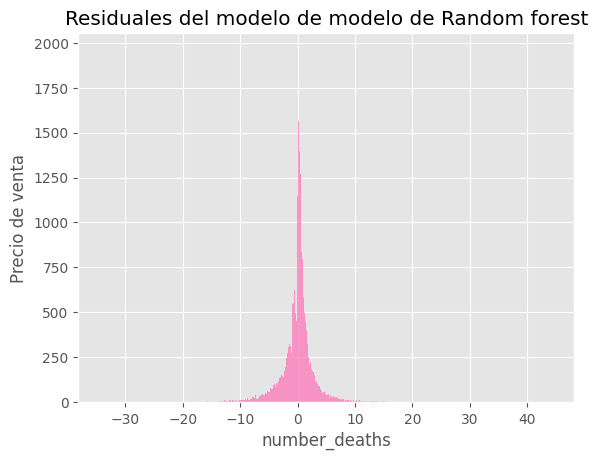

In [35]:
sns.histplot(residuales, color='hotpink');
plt.title("Residuales del modelo de modelo de Random forest")
plt.ylabel("Precio de venta")
plt.show()

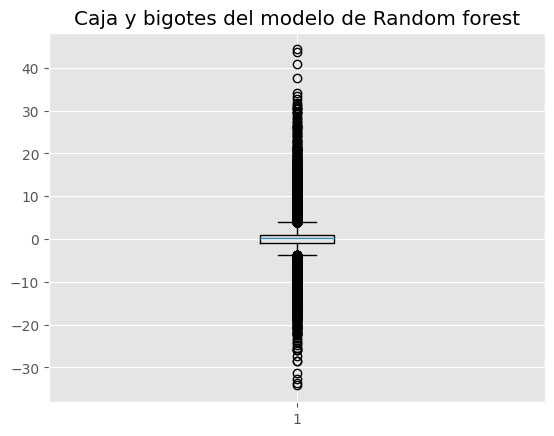

In [36]:
plt.boxplot(residuales)
plt.title('Caja y bigotes del modelo de Random forest')
plt.show()

# Árbol de decisión

In [37]:
# Creando y entrenando el modelo
modelo3 = DecisionTreeRegressor(max_depth=12, random_state=42)
modelo3 = modelo3.fit(X=predictors_train, y=target_train)

variance: 0.7833022592488332
Mean absolute Error: 2.034777812462329
Mean squared error: 12.910652102823477


,prediction,real
7527,18.833333,22
7680,5.500000,10
71623,2.000000,2
42531,4.272727,16
57820,3.062574,1
56866,1.687500,1
31168,28.000000,27
65320,1.826087,1
73637,7.000000,12
57093,2.111111,2


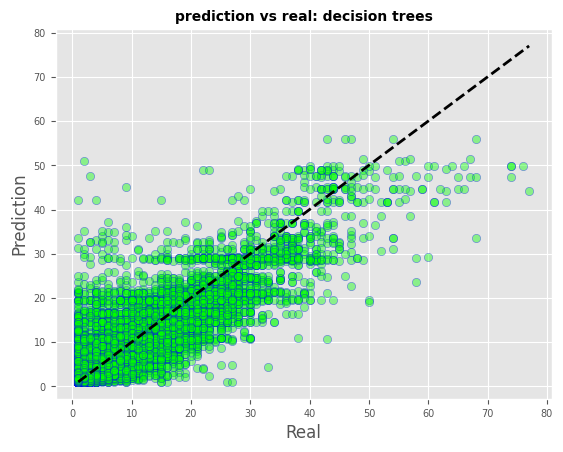

In [38]:
# Evaluando el modelo
prediccion = modelo3.predict(predictors_test)
results = pd.DataFrame({
    'prediction': prediccion,
    'real': target_test
})

print("variance:", explained_variance_score(target_test, prediccion))
print("Mean absolute Error:", mean_absolute_error(target_test, prediccion))
print("Mean squared error:", mean_squared_error(target_test, prediccion))

# Comparación entre valores predichos y valores reales
plt.scatter(target_test, prediccion, edgecolors=(0, 0, 1), c='lime', alpha=0.4)
plt.plot([target_test.min(), target_test.max()], [target_test.min(), target_test.max()], 'k--', lw=2)
plt.title('prediction vs real: decision trees', fontsize=10, fontweight="bold")
plt.xlabel('Real')
plt.ylabel('Prediction')
plt.tick_params(labelsize=7)

results.tail(10)


In [39]:
#model residuals
residuals  = prediccion - target_test

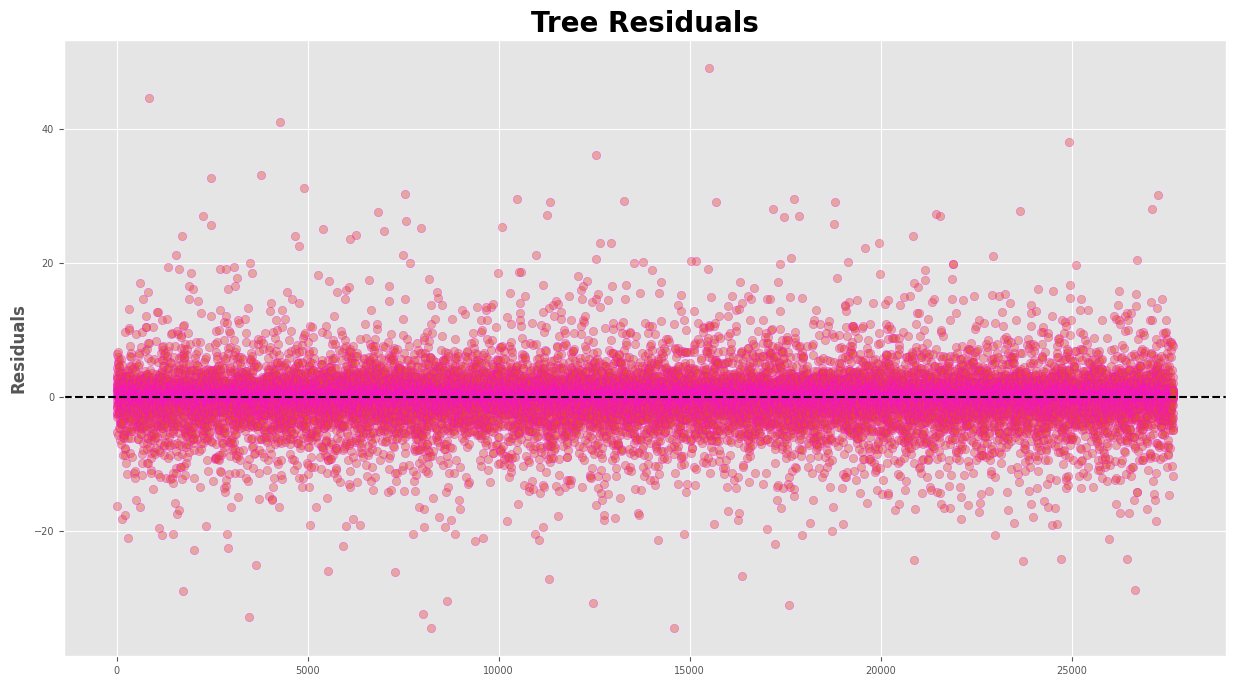

In [40]:
#Eficiencia del modelo
plt.figure(figsize=(15, 8))

# Residuos Modelo 3
plt.scatter(list(range(len(prediccion))), residuals,edgecolors=(1, 0, 1), alpha = 0.4)
plt.axhline(y = 0, linestyle = '--', color = 'black')
plt.title('Tree Residuals', fontsize = 20, fontweight = "bold")
plt.ylabel('Residuals',fontweight = "bold")
plt.tick_params(labelsize = 7)
plt.show()